In [35]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

In [36]:
def find_data_dir(start: Path) -> Path:
    start = start.resolve()
    for p in [start] + list(start.parents):
        candidate = p / "data" / "raw" / "sessions"
        if candidate.exists():
            return candidate
    raise FileNotFoundError(
        "Could not find data/raw/sessions by walking up from: " + str(start)
    )

DATA_DIR = find_data_dir(Path.cwd())

print("CWD:", Path.cwd().resolve())
print("DATA_DIR:", DATA_DIR)
print("Exists:", DATA_DIR.exists())

CWD: /Users/will/Documents/Behavioural-Biometrics-Data-Collection/Behavioural-Biometrics-Analysis/notebooks
DATA_DIR: /Users/will/Documents/Behavioural-Biometrics-Data-Collection/Behavioural-Biometrics-Analysis/data/raw/sessions
Exists: True


In [37]:
paths = sorted(DATA_DIR.glob("*/auth_windows.csv"))

print(f"Found {len(paths)} auth_windows files")
print("Session folders:", [p.parent.name for p in paths])

if len(paths) == 0:
    raise RuntimeError(f"No auth_windows.csv found under {DATA_DIR}")

df = pd.concat(
    [
        pd.read_csv(p).assign(session_id=p.parent.name)
        for p in paths
    ],
    ignore_index=True
)

print("Shape:", df.shape)
df.head()

Found 3 auth_windows files
Session folders: ['3be79cb28ce24d35b5b4c16cc51f8aac', 'b30211d252ca488692fd9dec68fbf740', 'cf7e7dad28b94d1f849c4e5e9eb7bc45']


Shape: (21, 33)


,sessionId,participantId,sessionIndex,timeBucket,fatigue,inputDevice,typing_ikt_global_mean,typing_ikt_global_std,typing_ikt_global_iqr,typing_ikt_global_p95,...,tap_miss_rate_pct,tap_drift_rt,tap_error_recovery_miss_median,coupling_var_ikt,coupling_var_rt,coupling_var_ratio,windowIndex,windowStartMs,windowEndMs,session_id
0,3be79cb28ce24d35b5b4c16cc51f8aac,pCURDWC,15,afternoon,2,trackpad,309.0,335.0,150.0,1116.0,...,0,NaN,NaN,112481.943346,NaN,NaN,0,456075,486075,3be79cb28ce24d35b5b4c16cc51f8aac
1,3be79cb28ce24d35b5b4c16cc51f8aac,pCURDWC,15,afternoon,2,trackpad,277.0,325.0,98.0,1090.0,...,0,NaN,NaN,105496.999909,NaN,NaN,1,471075,501075,3be79cb28ce24d35b5b4c16cc51f8aac
2,3be79cb28ce24d35b5b4c16cc51f8aac,pCURDWC,15,afternoon,2,trackpad,303.0,353.0,122.0,1111.0,...,0,NaN,NaN,124409.280273,NaN,NaN,2,486075,516075,3be79cb28ce24d35b5b4c16cc51f8aac
3,3be79cb28ce24d35b5b4c16cc51f8aac,pCURDWC,15,afternoon,2,trackpad,359.0,385.0,333.0,1122.0,...,13,NaN,NaN,147866.510191,120634.987500,0.816,3,501075,531075,3be79cb28ce24d35b5b4c16cc51f8aac
4,3be79cb28ce24d35b5b4c16cc51f8aac,pCURDWC,15,afternoon,2,trackpad,NaN,NaN,NaN,NaN,...,8,-177.0,NaN,NaN,65104.245747,NaN,4,516075,546075,3be79cb28ce24d35b5b4c16cc51f8aac


In [38]:
required = ["participantId","sessionId","windowIndex","windowStartMs","windowEndMs"]
missing_cols = [c for c in required if c not in df.columns]
assert not missing_cols, f"Missing required columns: {missing_cols}"

# one row per window identifier
dupes = df.duplicated(subset=["participantId","sessionId","windowIndex"]).sum()
print("Duplicate (participantId,sessionId,windowIndex) rows:", dupes)

# window counts per session
counts = df.groupby(["participantId","sessionId"])["windowIndex"].count().sort_values()
print("Window count per session — summary:")
display(counts.describe())

print("Example sessions (lowest counts):")
display(counts.head(10))

Duplicate (participantId,sessionId,windowIndex) rows: 0
Window count per session — summary:


count    3.0
mean     7.0
std      0.0
min      7.0
25%      7.0
50%      7.0
75%      7.0
max      7.0
Name: windowIndex, dtype: float64

Example sessions (lowest counts):


participantId  sessionId                       
pCURDWC        3be79cb28ce24d35b5b4c16cc51f8aac    7
               b30211d252ca488692fd9dec68fbf740    7
               cf7e7dad28b94d1f849c4e5e9eb7bc45    7
Name: windowIndex, dtype: int64

In [39]:
def is_monotonic(g):
    return g["windowIndex"].is_monotonic_increasing and g["windowStartMs"].is_monotonic_increasing

mono = df.groupby(["participantId","sessionId"]).apply(is_monotonic)
print(mono.value_counts())

True    3
Name: count, dtype: int64


/var/folders/35/vxjl_n4s1xg11npkpzsxjjkc0000gn/T/ipykernel_14076/2811569696.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mono = df.groupby(["participantId","sessionId"]).apply(is_monotonic)


In [40]:
missing_frac = df.isna().mean().sort_values(ascending=False)
missing_pct = (100 * missing_frac).round(1)

missing_table = pd.DataFrame({
    "missing_%": missing_pct,
    "non_missing_n": df.notna().sum()
})

display(missing_table.head(30))

,missing_%,non_missing_n
coupling_var_ikt,42.9,12
coupling_var_ratio,85.7,3
coupling_var_rt,42.9,12
fatigue,0.0,21
inputDevice,0.0,21
participantId,0.0,21
sessionId,0.0,21
sessionIndex,0.0,21
session_id,0.0,21
tap_drift_rt,57.1,9


In [41]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

by_w = df.groupby("windowIndex")[numeric_cols].apply(lambda x: x.isna().mean()).T * 100
by_w = by_w.round(1)

# show a few key features if present
key_feats = [c for c in [
    "typing_drift_ikt",
    "tap_drift_rt",
    "typing_error_recovery_wrong_median",
    "tap_error_recovery_miss_median",
    "typing_accuracy_pct",
    "tap_miss_rate_pct"
] if c in df.columns]

display(by_w.loc[key_feats] if key_feats else by_w.head(10))

windowIndex,0,1,2,3,4,5,6
typing_drift_ikt,0.0,0.0,0.0,100.0,100.0,100.0,100.0
tap_drift_rt,100.0,100.0,100.0,100.0,0.0,0.0,0.0
typing_error_recovery_wrong_median,100.0,100.0,100.0,100.0,100.0,100.0,100.0
tap_error_recovery_miss_median,100.0,100.0,100.0,100.0,100.0,100.0,100.0
typing_accuracy_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tap_miss_rate_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Core cols found: ['typing_ikt_global_mean', 'typing_ikt_global_p95', 'typing_accuracy_pct', 'tap_rt_mean', 'tap_rt_p95', 'tap_miss_rate_pct', 'coupling_var_ratio']


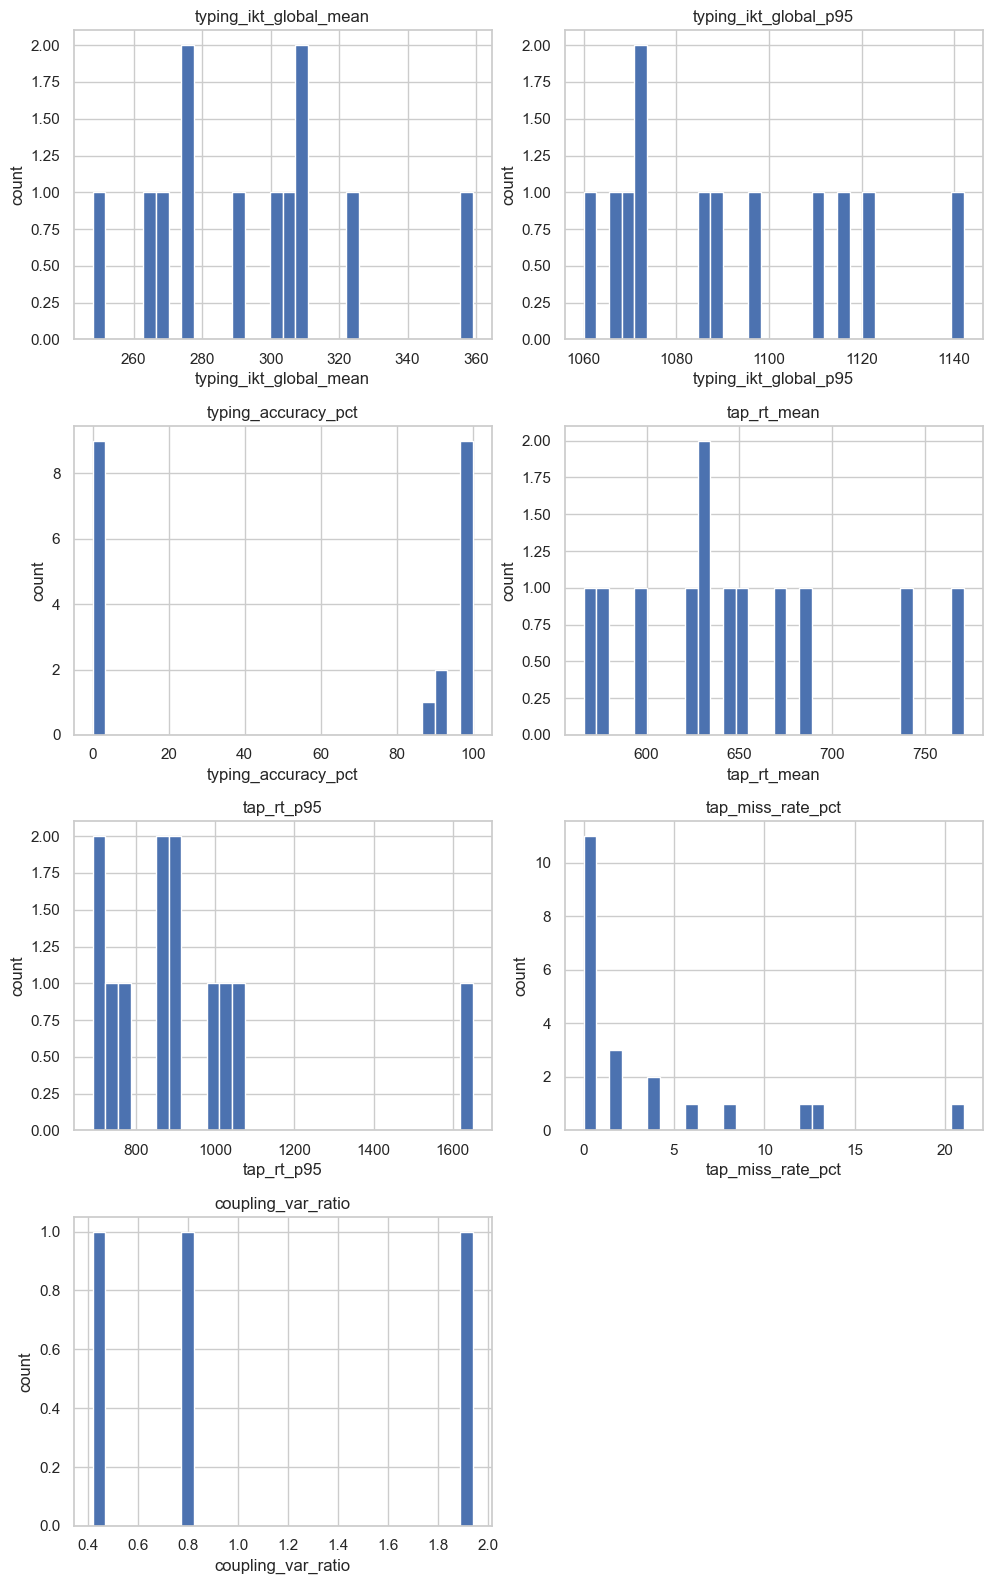

In [42]:
core = [c for c in [
    "typing_ikt_global_mean",
    "typing_ikt_global_p95",
    "typing_accuracy_pct",
    "tap_rt_mean",
    "tap_rt_p95",
    "tap_miss_rate_pct",
    "coupling_var_ratio"
] if c in df.columns]

print("Core cols found:", core)

n = len(core)
fig, axes = plt.subplots((n+1)//2, 2, figsize=(10, 4*((n+1)//2)))
axes = np.array(axes).reshape(-1)

for ax, col in zip(axes, core):
    x = df[col].dropna()
    ax.hist(x, bins=30)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("count")

# tidy extra axes
for ax in axes[len(core):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [43]:
checks = []

def add_check(col, lo, hi):
    if col in df.columns:
        x = df[col].dropna()
        bad = ((x < lo) | (x > hi)).sum()
        checks.append((col, lo, hi, int(bad), float(x.min()), float(x.max())))

# Broad “human plausible” bounds (not strict)
add_check("typing_ikt_global_mean", 50, 1500)
add_check("typing_ikt_global_p95", 100, 4000)
add_check("tap_rt_mean", 100, 3000)
add_check("tap_rt_p95", 150, 5000)
add_check("typing_accuracy_pct", 0, 100)
add_check("tap_miss_rate_pct", 0, 100)
add_check("coupling_var_ratio", 0, 10)

check_df = pd.DataFrame(checks, columns=["feature","lo","hi","n_outside","min","max"])
display(check_df)

,feature,lo,hi,n_outside,min,max
0,typing_ikt_global_mean,50,1500,0,248.000,359.000
1,typing_ikt_global_p95,100,4000,0,1060.000,1142.000
2,tap_rt_mean,100,3000,0,566.000,771.000
3,tap_rt_p95,150,5000,0,690.000,1650.000
4,typing_accuracy_pct,0,100,0,0.000,100.000
5,tap_miss_rate_pct,0,100,0,0.000,21.000
6,coupling_var_ratio,0,10,0,0.417,1.937


In [44]:
if df["participantId"].nunique() >= 2:
    # Between-user vs within-user variance per feature (rough proxy)
    feats = [c for c in numeric_cols if c not in ["windowStartMs","windowEndMs","windowIndex"]]
    feats = [c for c in feats if df[c].notna().sum() > 0]

    user_means = df.groupby("participantId")[feats].mean(numeric_only=True)
    between = user_means.var()

    within = df.groupby("participantId")[feats].var().mean()

    signal = (between / (within + 1e-9)).sort_values(ascending=False)
    display(signal.head(20).to_frame("between/within"))
else:
    print("Need >=2 participants to compute between/within-user variance proxy.")

Need >=2 participants to compute between/within-user variance proxy.
